cuda
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.39e+00 | test_loss: 7.74e+00 | reg: 1.38e+01 | : 100%|█| 100/100 [00:05<00:00, 19.79


saving model version 0.1
MAE: 6.1049
MSE: 59.8667
MAPE: 6.2029
R²: 0.7626
RMSE: 7.7374
fixing (0,0,0) with cos, r2=1.000000238418579, c=2
fixing (0,1,0) with cos, r2=1.0000003576278687, c=2
fixing (0,2,0) with log10, r2=0.9812806844711304, c=1
fixing (0,3,0) with cos, r2=1.0000001192092896, c=2
saving model version 0.2


/opt/conda/lib/python3.11/site-packages/sympy/core/sympify.py:475: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return sympify(float(a))


41.735*log10(0.582*x_3 + 6.212) + 4.828*cos(8.233*x_1 + 8.133) - 8.305*cos(6.831*x_2 - 5.683) + 0.762*cos(8.088*x_4 - 2.127) + 37.867

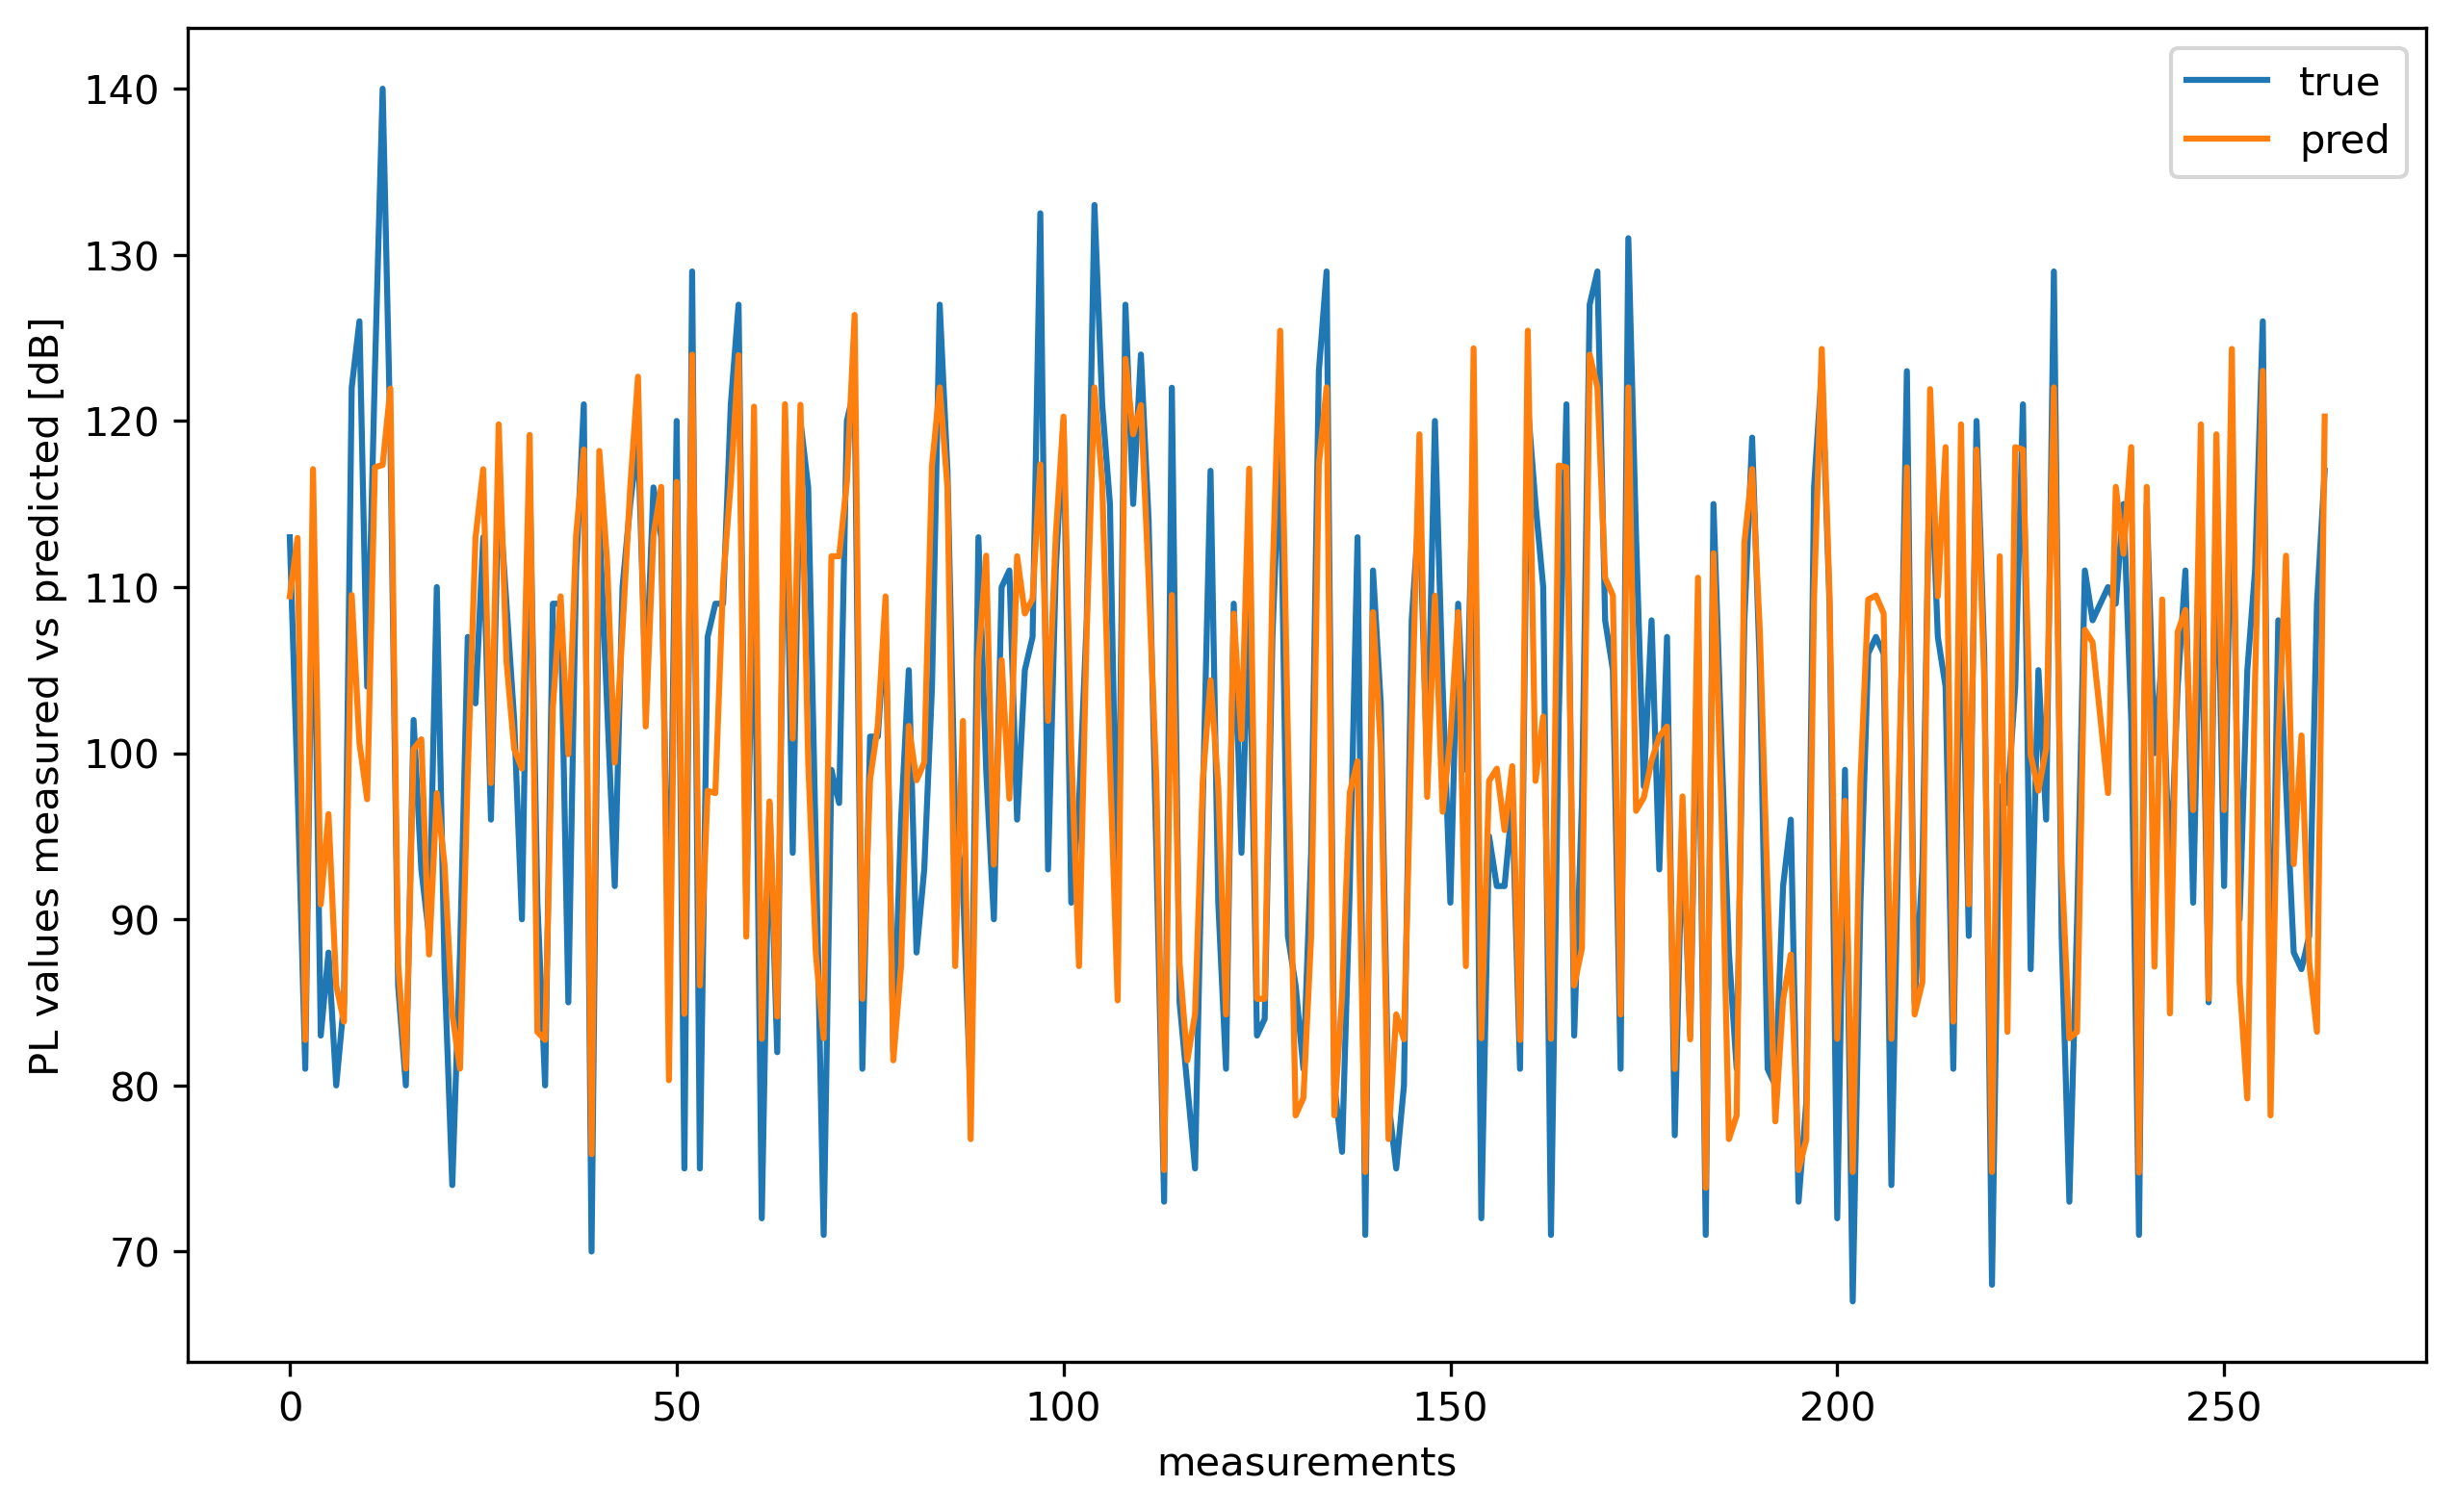

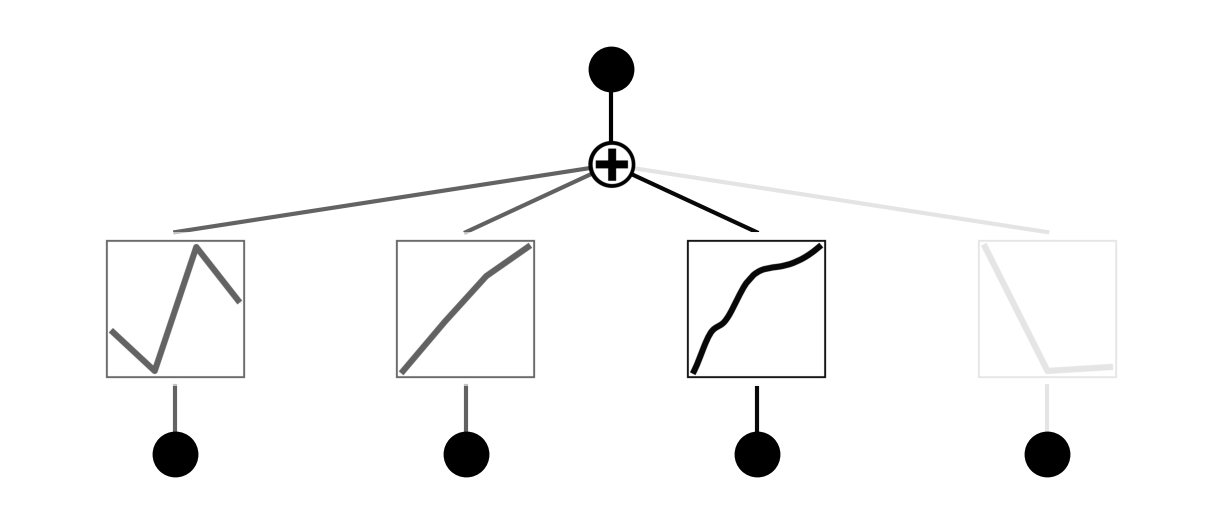

In [2]:

from kan import *
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, f, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()
    y_pred = y_pred.detach().cpu().numpy().ravel()
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    if f is not nan:
        y_symbolic = f(test_data['test_input'])
        plt.plot(time, y_symbolic)
        plt.legend(['true', 'pred', 'symbolic'])
    else:
        plt.legend(['true', 'pred'])
    plt.ylabel('PL values measured vs predicted [dB]')
    plt.xlabel('measurements')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label='metric')
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


# Read the data from the Excel file
indoor_data = pd.read_excel('csv_experiments.xlsx', sheet_name='Indoor', header=0)

# Assuming `inputs` and `labels` are your raw data as numpy arrays
inputs = indoor_data[['nw', 'nf', 'd', 'f']].values  # Input features (f and d)
labels = indoor_data['PL'].values    # Output labels 
train_input, test_input, train_label, test_label = train_test_split(
    inputs, labels, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_input = torch.tensor(train_input, dtype=torch.float32).to(device)
test_input = torch.tensor(test_input, dtype=torch.float32).to(device)

train_label = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1).to(device)
test_label = torch.tensor(test_label, dtype=torch.float32).unsqueeze(1).to(device)

# Prepare the dataset dictionary
dataset = {}
dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = train_label
dataset['test_label'] = test_label

model = KAN(width=[4,1], grid=5, k=3, seed=42, device=device)

# this is the learnt KAN model (splines + edge weights)
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.0002, lamb_entropy=2.);

eval_kan(model, nan, dataset)
model.plot()

# this is the symbolic approximation of the learnt splines with interpretable mathematical functions
add_symbolic('log10', torch.log10)
model.auto_symbolic()

ex_round(model.symbolic_formula()[0][0], 3)



MAE: 6.2668
MSE: 61.6216
MAPE: 6.3761
R²: 0.7556
RMSE: 7.8499


/var/folders/kp/ywhxwl8j55z_9fb901tc6x_w0000gp/T/ipykernel_21446/795080839.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: 52.026 * np.log10(2.408 * x[:, 1] + 8.63) + 41.516 * np.log10(0.383 * x[:, 2] + 4.03) + 4.912 * np.sin(8.226 * x[:, 0] - 2.854) - 1.328 * np.cos(5.036 * x[:, 3] - 0.448) - 11.236


(61.62157440185547,
 np.float64(7.849941044482785),
 6.266800403594971,
 6.376068294048309,
 0.7555981874465942)

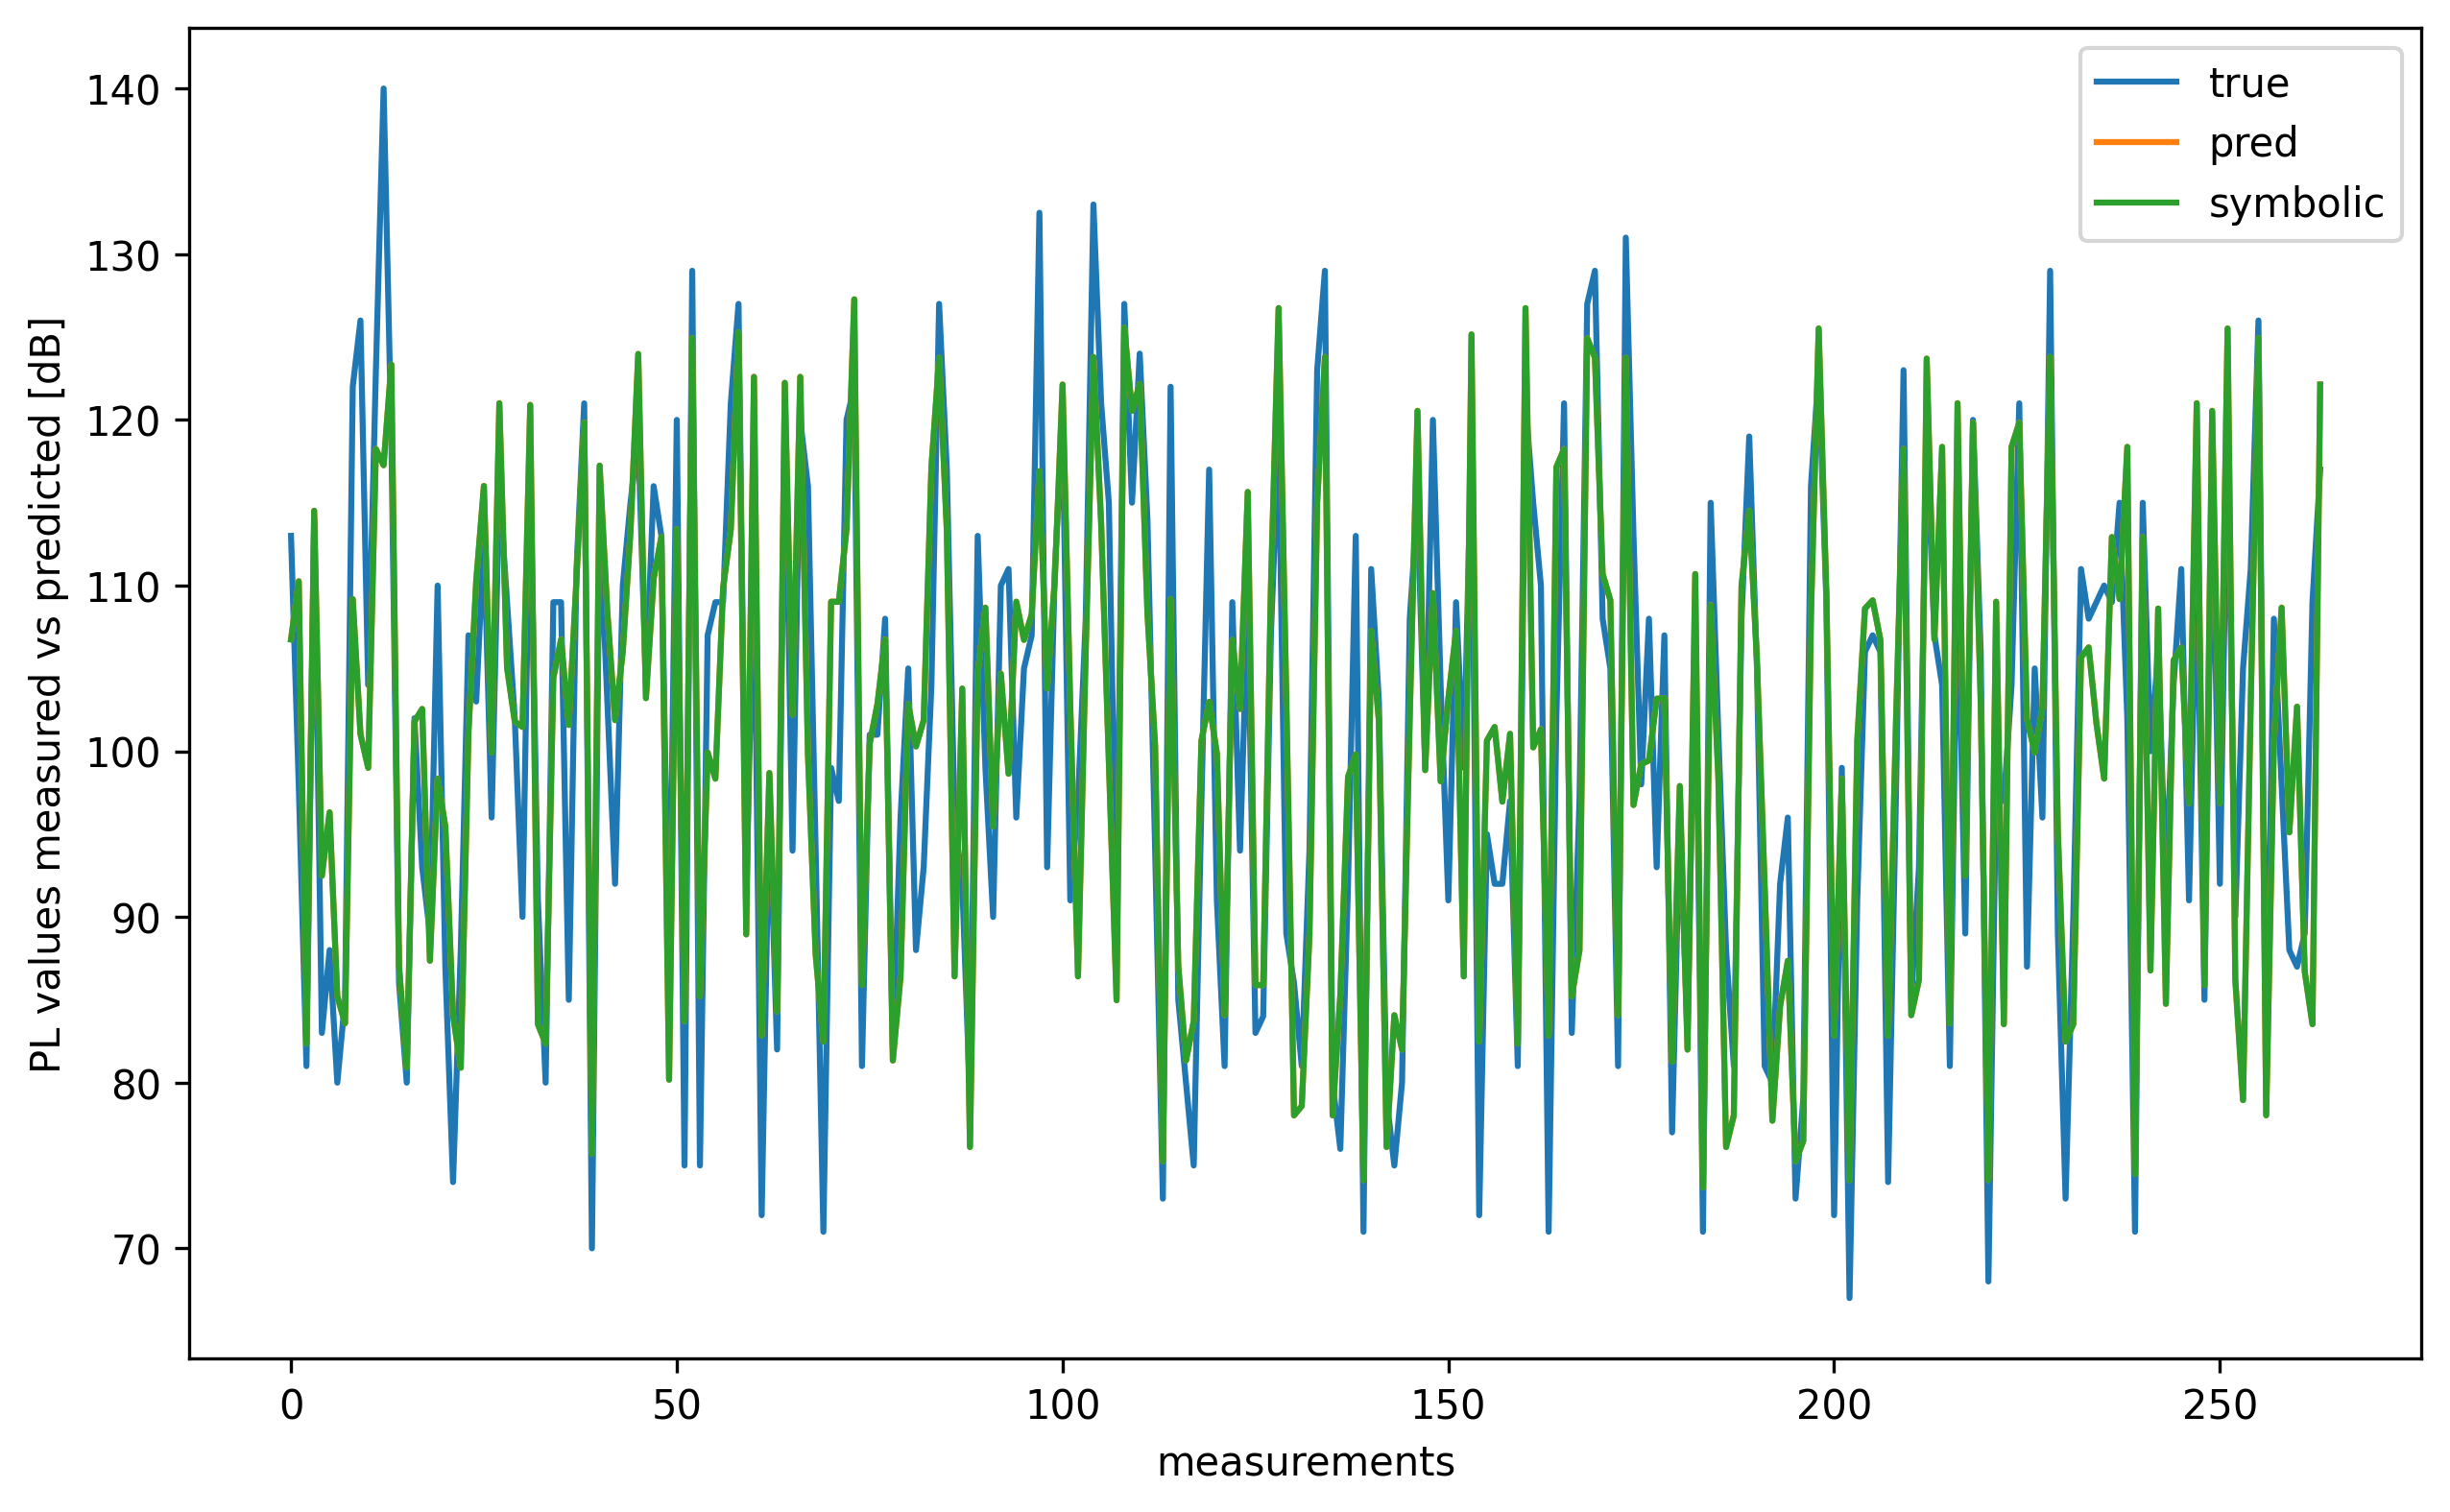

In [2]:

f = lambda x: 52.026 * np.log10(2.408 * x[:, 1] + 8.63) + 41.516 * np.log10(0.383 * x[:, 2] + 4.03) + 4.912 * np.sin(8.226 * x[:, 0] - 2.854) - 1.328 * np.cos(5.036 * x[:, 3] - 0.448) - 11.236

eval_kan(model, f, dataset)




In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[4,1], 
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s], lamb_entropy=2.)
            
            train_losses += results['train_loss']
            test_losses += results['test_loss']
            #print(np.array(train_losses).mean())

            if not np.isnan(results['train_loss']).any():
                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, nan, dataset);
                #te_mse, te_rmse, te_mae, te_mape, te_r2 = eval_kan(model, validation_data);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)


## Multiple KAN runs (10)

In [3]:
from kan import *
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import copy

# --- Device Configuration ---
# Recommendation: Use CPU for LBFGS stability with KANs to avoid NaNs
device = torch.device('cpu') 
print(f"Using device: {device}")

# --- 1. Data Loading ---
try:
    indoor_data = pd.read_excel('csv_experiments.xlsx', sheet_name='Indoor', header=0)
except FileNotFoundError:
    print("Warning: 'csv_experiments.xlsx' not found. Generating dummy data...")
    # Dummy data with 4 columns: nw, nf, d, f
    indoor_data = pd.DataFrame({
        'nw': np.random.randint(1, 5, 100),
        'nf': np.random.randint(1, 5, 100),
        'd': np.random.uniform(1, 50, 100),
        'f': np.random.uniform(2e9, 5e9, 100),
        'PL': np.random.uniform(40, 90, 100)
    })

# Extract raw values
all_inputs = indoor_data[['nw', 'nf', 'd', 'f']].values.astype(np.float32)
all_labels = indoor_data['PL'].values.astype(np.float32)

# --- 2. Helper Functions ---
def calculate_metrics(y_true, y_pred):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    
    if np.isnan(y_pred).any():
        return {k: np.nan for k in ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']}
        
    mse = mean_squared_error(y_true, y_pred)
    return {
        'MSE': mse, 
        'RMSE': np.sqrt(mse), 
        'MAE': mean_absolute_error(y_true, y_pred), 
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100, 
        'R2': r2_score(y_true, y_pred)
    }

# --- 3. 10-Run Statistical Loop ---
num_runs = 10
results_learnt = {'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': [], 'R2': []}
results_symbolic = {'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': [], 'R2': []}

best_learnt_r2 = -np.inf
best_model_state = None
best_dataset_split = {}
best_formula_str = ""

print(f"Starting {num_runs} runs on INDOOR data (nw, nf, d, f)...")

for run in range(num_runs):
    # A. Split
    train_input, test_input, train_label, test_label = train_test_split(
        all_inputs, all_labels, test_size=0.2, random_state=run
    )

    # B. Scaling (Crucial for KAN stability)
    # Range 0.1 to 1.0 to stay positive for logs, but bounded for splines
    scaler = MinMaxScaler(feature_range=(0.1, 1.0))
    train_input = scaler.fit_transform(train_input)
    test_input = scaler.transform(test_input)

    # C. Prepare Dataset
    dataset = {
        'train_input': torch.tensor(train_input).to(device),
        'test_input': torch.tensor(test_input).to(device),
        'train_label': torch.tensor(train_label).unsqueeze(1).to(device),
        'test_label': torch.tensor(test_label).unsqueeze(1).to(device)
    }

    # D. Initialize KAN
    # width=[4,1] for 4 inputs (nw, nf, d, f) -> 1 output
    model = KAN(width=[4,1], grid=5, k=3, seed=run, device=device)

    # E. Train (Learnt Phase)
    try:
        model.fit(dataset, opt="LBFGS", steps=100, lamb=0.0002, lamb_entropy=2.0);
    except Exception as e:
        print(f"Run {run+1} Training Failed: {e}")
        continue

    # F. Evaluate Learnt
    preds_learnt = model(dataset['test_input']).detach().cpu().numpy()
    if np.isnan(preds_learnt).any():
        print(f"Run {run+1}: NaNs in Learnt predictions. Skipping.")
        continue

    metrics_learnt = calculate_metrics(dataset['test_label'].cpu().numpy(), preds_learnt)
    for k, v in metrics_learnt.items(): results_learnt[k].append(v)

    # G. Auto Symbolic
    # Add custom log10 and define library
    # Note: 'add_symbolic' adds to the global library, so we do it safely
    try:
        add_symbolic('log10', torch.log10)
    except:
        pass # Already added

    lib = ['x','x^2','log10','sqrt','exp'] 
    
    try:
        model.auto_symbolic(lib=lib)
        preds_symbolic = model(dataset['test_input']).detach().cpu().numpy()
        metrics_symbolic = calculate_metrics(dataset['test_label'].cpu().numpy(), preds_symbolic)
        
        for k, v in metrics_symbolic.items(): results_symbolic[k].append(v)
        
        print(f"Run {run+1}: Learnt R²={metrics_learnt['R2']:.4f} | Sym R²={metrics_symbolic['R2']:.4f}")

        # Save Best
        if metrics_learnt['R2'] > best_learnt_r2:
            best_learnt_r2 = metrics_learnt['R2']
            best_model_state = copy.deepcopy(model)
            best_dataset_split = dataset
            try:
                best_formula_str = model.symbolic_formula()[0][0]
            except:
                best_formula_str = "Formula Error"
                
    except Exception as e:
        print(f"Run {run+1} Symbolic Failed: {e}")
        for k in results_symbolic: results_symbolic[k].append(np.nan)

# --- 4. Final Statistics ---
print("\n" + "="*40)
print(f"INDOOR KAN STATISTICS ({num_runs} Runs)")
print("="*40)

print("\n--- LEARNT KAN ---")
summary_learnt = pd.DataFrame(results_learnt).describe().loc[['mean', 'std']].T
summary_learnt['formatted'] = summary_learnt.apply(lambda x: f"{x['mean']:.4f} ± {x['std']:.4f}", axis=1)
print(summary_learnt['formatted'])

print("\n--- SYMBOLIC KAN ---")
summary_sym = pd.DataFrame(results_symbolic).describe().loc[['mean', 'std']].T
summary_sym['formatted'] = summary_sym.apply(lambda x: f"{x['mean']:.4f} ± {x['std']:.4f}", axis=1)
print(summary_sym['formatted'])

# --- 5. Plot Best Run ---
if best_model_state is not None:
    print(f"\nPlotting Best Run (Learnt R²: {best_learnt_r2:.4f})")
    
    # Predict
    y_true = best_dataset_split['test_label'].cpu().numpy().ravel()
    y_pred = best_model_state(best_dataset_split['test_input']).detach().cpu().numpy().ravel()
    
    # Plot
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(range(len(y_true)), y_true, label='True')
    plt.plot(range(len(y_pred)), y_pred, label='Symbolic Pred', linestyle='--')
    plt.legend()
    plt.title(f"Best KAN on Indoor Data")
    plt.xlabel('Measurements')
    plt.ylabel('PL [dB]')
    plt.show()

    print("\nBest Symbolic Formula:")
    try:
        print(ex_round(best_model_state.symbolic_formula()[0][0], 3))
    except:
        print(best_formula_str)

    # Plot KAN structure
    best_model_state.plot()
    plt.show()

Using device: cpu
Starting 10 runs on INDOOR data (nw, nf, d, f)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.45e+00 | test_loss: 7.36e+00 | reg: 5.19e+01 | : 100%|█| 100/100 [00:06<00:00, 15.99


saving model version 0.1
fixing (0,0,0) with log10, r2=0.24572713673114777, c=1
fixing (0,1,0) with log10, r2=0.9657348394393921, c=1
fixing (0,2,0) with log10, r2=0.9693682789802551, c=1
fixing (0,3,0) with log10, r2=1.0000007152557373, c=1
saving model version 0.2
Run 1: Learnt R²=0.7556 | Sym R²=0.7376
Run 1 Symbolic Failed: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment.  If you were attempting to deepcopy a module, this may be because of a torch.nn.utils.weight_norm usage, see https://github.com/pytorch/pytorch/pull/103001
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.36e+00 | test_loss: 7.69e+00 | reg: 5.08e+01 | : 100%|█| 100/100 [00:06<00:00, 15.19


saving model version 0.1
fixing (0,0,0) with log10, r2=0.26799604296684265, c=1
fixing (0,1,0) with log10, r2=0.9854660034179688, c=1
fixing (0,2,0) with log10, r2=0.9631678462028503, c=1
fixing (0,3,0) with x^2, r2=1.0000005960464478, c=2
saving model version 0.2
Run 2: Learnt R²=0.7786 | Sym R²=0.7483
Run 2 Symbolic Failed: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment.  If you were attempting to deepcopy a module, this may be because of a torch.nn.utils.weight_norm usage, see https://github.com/pytorch/pytorch/pull/103001
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.32e+00 | test_loss: 7.79e+00 | reg: 5.20e+01 | : 100%|█| 100/100 [00:06<00:00, 15.02


saving model version 0.1
fixing (0,0,0) with log10, r2=0.22883008420467377, c=1
fixing (0,1,0) with log10, r2=0.9696043729782104, c=1
fixing (0,2,0) with log10, r2=0.9729575514793396, c=1
fixing (0,3,0) with log10, r2=1.0000005960464478, c=1
saving model version 0.2
Run 3: Learnt R²=0.7455 | Sym R²=0.7223
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.31e+00 | test_loss: 7.87e+00 | reg: 5.19e+01 | : 100%|█| 100/100 [00:05<00:00, 18.16


saving model version 0.1
fixing (0,0,0) with log10, r2=0.3032473921775818, c=1
fixing (0,1,0) with log10, r2=0.9838563799858093, c=1
fixing (0,2,0) with log10, r2=0.9762499332427979, c=1
fixing (0,3,0) with log10, r2=1.0000004768371582, c=1
saving model version 0.2
Run 4: Learnt R²=0.7485 | Sym R²=0.7184
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.81e+00 | test_loss: 7.42e+00 | reg: 5.10e+01 | : 100%|█| 100/100 [00:09<00:00, 10.57


saving model version 0.1
fixing (0,0,0) with log10, r2=0.4354605972766876, c=1
fixing (0,1,0) with log10, r2=0.7621949315071106, c=1
fixing (0,2,0) with log10, r2=0.9779407382011414, c=1
fixing (0,3,0) with log10, r2=1.0000005960464478, c=1
saving model version 0.2
Run 5: Learnt R²=0.7771 | Sym R²=0.7749
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.36e+00 | test_loss: 7.61e+00 | reg: 5.21e+01 | : 100%|█| 100/100 [00:08<00:00, 11.57


saving model version 0.1
fixing (0,0,0) with log10, r2=0.22977927327156067, c=1
fixing (0,1,0) with log10, r2=0.9667164087295532, c=1
fixing (0,2,0) with log10, r2=0.9742255210876465, c=1
fixing (0,3,0) with log10, r2=1.0000008344650269, c=1
saving model version 0.2
Run 6: Learnt R²=0.7708 | Sym R²=0.7399
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.48e+00 | test_loss: 7.22e+00 | reg: 5.17e+01 | : 100%|█| 100/100 [00:05<00:00, 19.05


saving model version 0.1
fixing (0,0,0) with log10, r2=0.2662859857082367, c=1
fixing (0,1,0) with log10, r2=0.9822498559951782, c=1
fixing (0,2,0) with log10, r2=0.976326048374176, c=1
fixing (0,3,0) with log10, r2=1.0000005960464478, c=1
saving model version 0.2
Run 7: Learnt R²=0.7970 | Sym R²=0.7705
Run 7 Symbolic Failed: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment.  If you were attempting to deepcopy a module, this may be because of a torch.nn.utils.weight_norm usage, see https://github.com/pytorch/pytorch/pull/103001
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.65e+00 | test_loss: 7.46e+00 | reg: 5.26e+01 | : 100%|█| 100/100 [00:08<00:00, 11.67


saving model version 0.1
fixing (0,0,0) with log10, r2=0.16628196835517883, c=1
fixing (0,1,0) with log10, r2=0.9987814426422119, c=1
fixing (0,2,0) with log10, r2=0.9587229490280151, c=1
fixing (0,3,0) with log10, r2=0.9999997615814209, c=1
saving model version 0.2
Run 8: Learnt R²=0.7716 | Sym R²=0.7653
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.36e+00 | test_loss: 7.66e+00 | reg: 5.18e+01 | : 100%|█| 100/100 [00:07<00:00, 13.67


saving model version 0.1
fixing (0,0,0) with log10, r2=0.24797546863555908, c=1
fixing (0,1,0) with log10, r2=0.9847996234893799, c=1
fixing (0,2,0) with log10, r2=0.9674827456474304, c=1
fixing (0,3,0) with x^2, r2=1.0000008344650269, c=2
saving model version 0.2
Run 9: Learnt R²=0.7701 | Sym R²=0.7393
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.32e+00 | test_loss: 7.83e+00 | reg: 5.17e+01 | : 100%|█| 100/100 [00:06<00:00, 15.39


saving model version 0.1
fixing (0,0,0) with log10, r2=0.21389733254909515, c=1
fixing (0,1,0) with log10, r2=0.9830752611160278, c=1
fixing (0,2,0) with log10, r2=0.9678649306297302, c=1
fixing (0,3,0) with x^2, r2=1.0000003576278687, c=2
saving model version 0.2
Run 10: Learnt R²=0.7356 | Sym R²=0.6979

INDOOR KAN STATISTICS (10 Runs)

--- LEARNT KAN ---
MSE     57.6724 ± 3.2968
RMSE     7.5914 ± 0.2180
MAE      5.8851 ± 0.1330
MAPE     5.8367 ± 0.1244
R2       0.7650 ± 0.0185
Name: formatted, dtype: object

--- SYMBOLIC KAN ---
MSE     63.5052 ± 5.4137
RMSE     7.9624 ± 0.3421
MAE      6.3297 ± 0.2311
MAPE     6.3282 ± 0.2073
R2       0.7414 ± 0.0245
Name: formatted, dtype: object


# Evaluation of resnet-MLP and TabNet

In [ ]:
!pip install pytorch_tabnet

## resnet-MLP loop

Starting 10 runs (Reshuffling Data Each Time)...
Run 1: R²=0.7881 | MSE=46.9918
Run 2: R²=0.7892 | MSE=56.3599
Run 3: R²=0.7600 | MSE=57.2484
Run 4: R²=0.7213 | MSE=68.5913
Run 5: R²=0.8230 | MSE=43.7260
Run 6: R²=0.7899 | MSE=53.0289
Run 7: R²=0.8038 | MSE=50.3599
Run 8: R²=0.7943 | MSE=50.1260
Run 9: R²=0.7479 | MSE=64.3683
Run 10: R²=0.7462 | MSE=58.8795

FINAL STATISTICS (10 different splits)
MSE     54.9680 ± 7.7089
RMSE     7.3978 ± 0.5170
MAE      5.6681 ± 0.3813
MAPE     5.5355 ± 0.3621
R2       0.7764 ± 0.0312
Name: formatted, dtype: object

Plotting Best Run (R²: 0.8230)


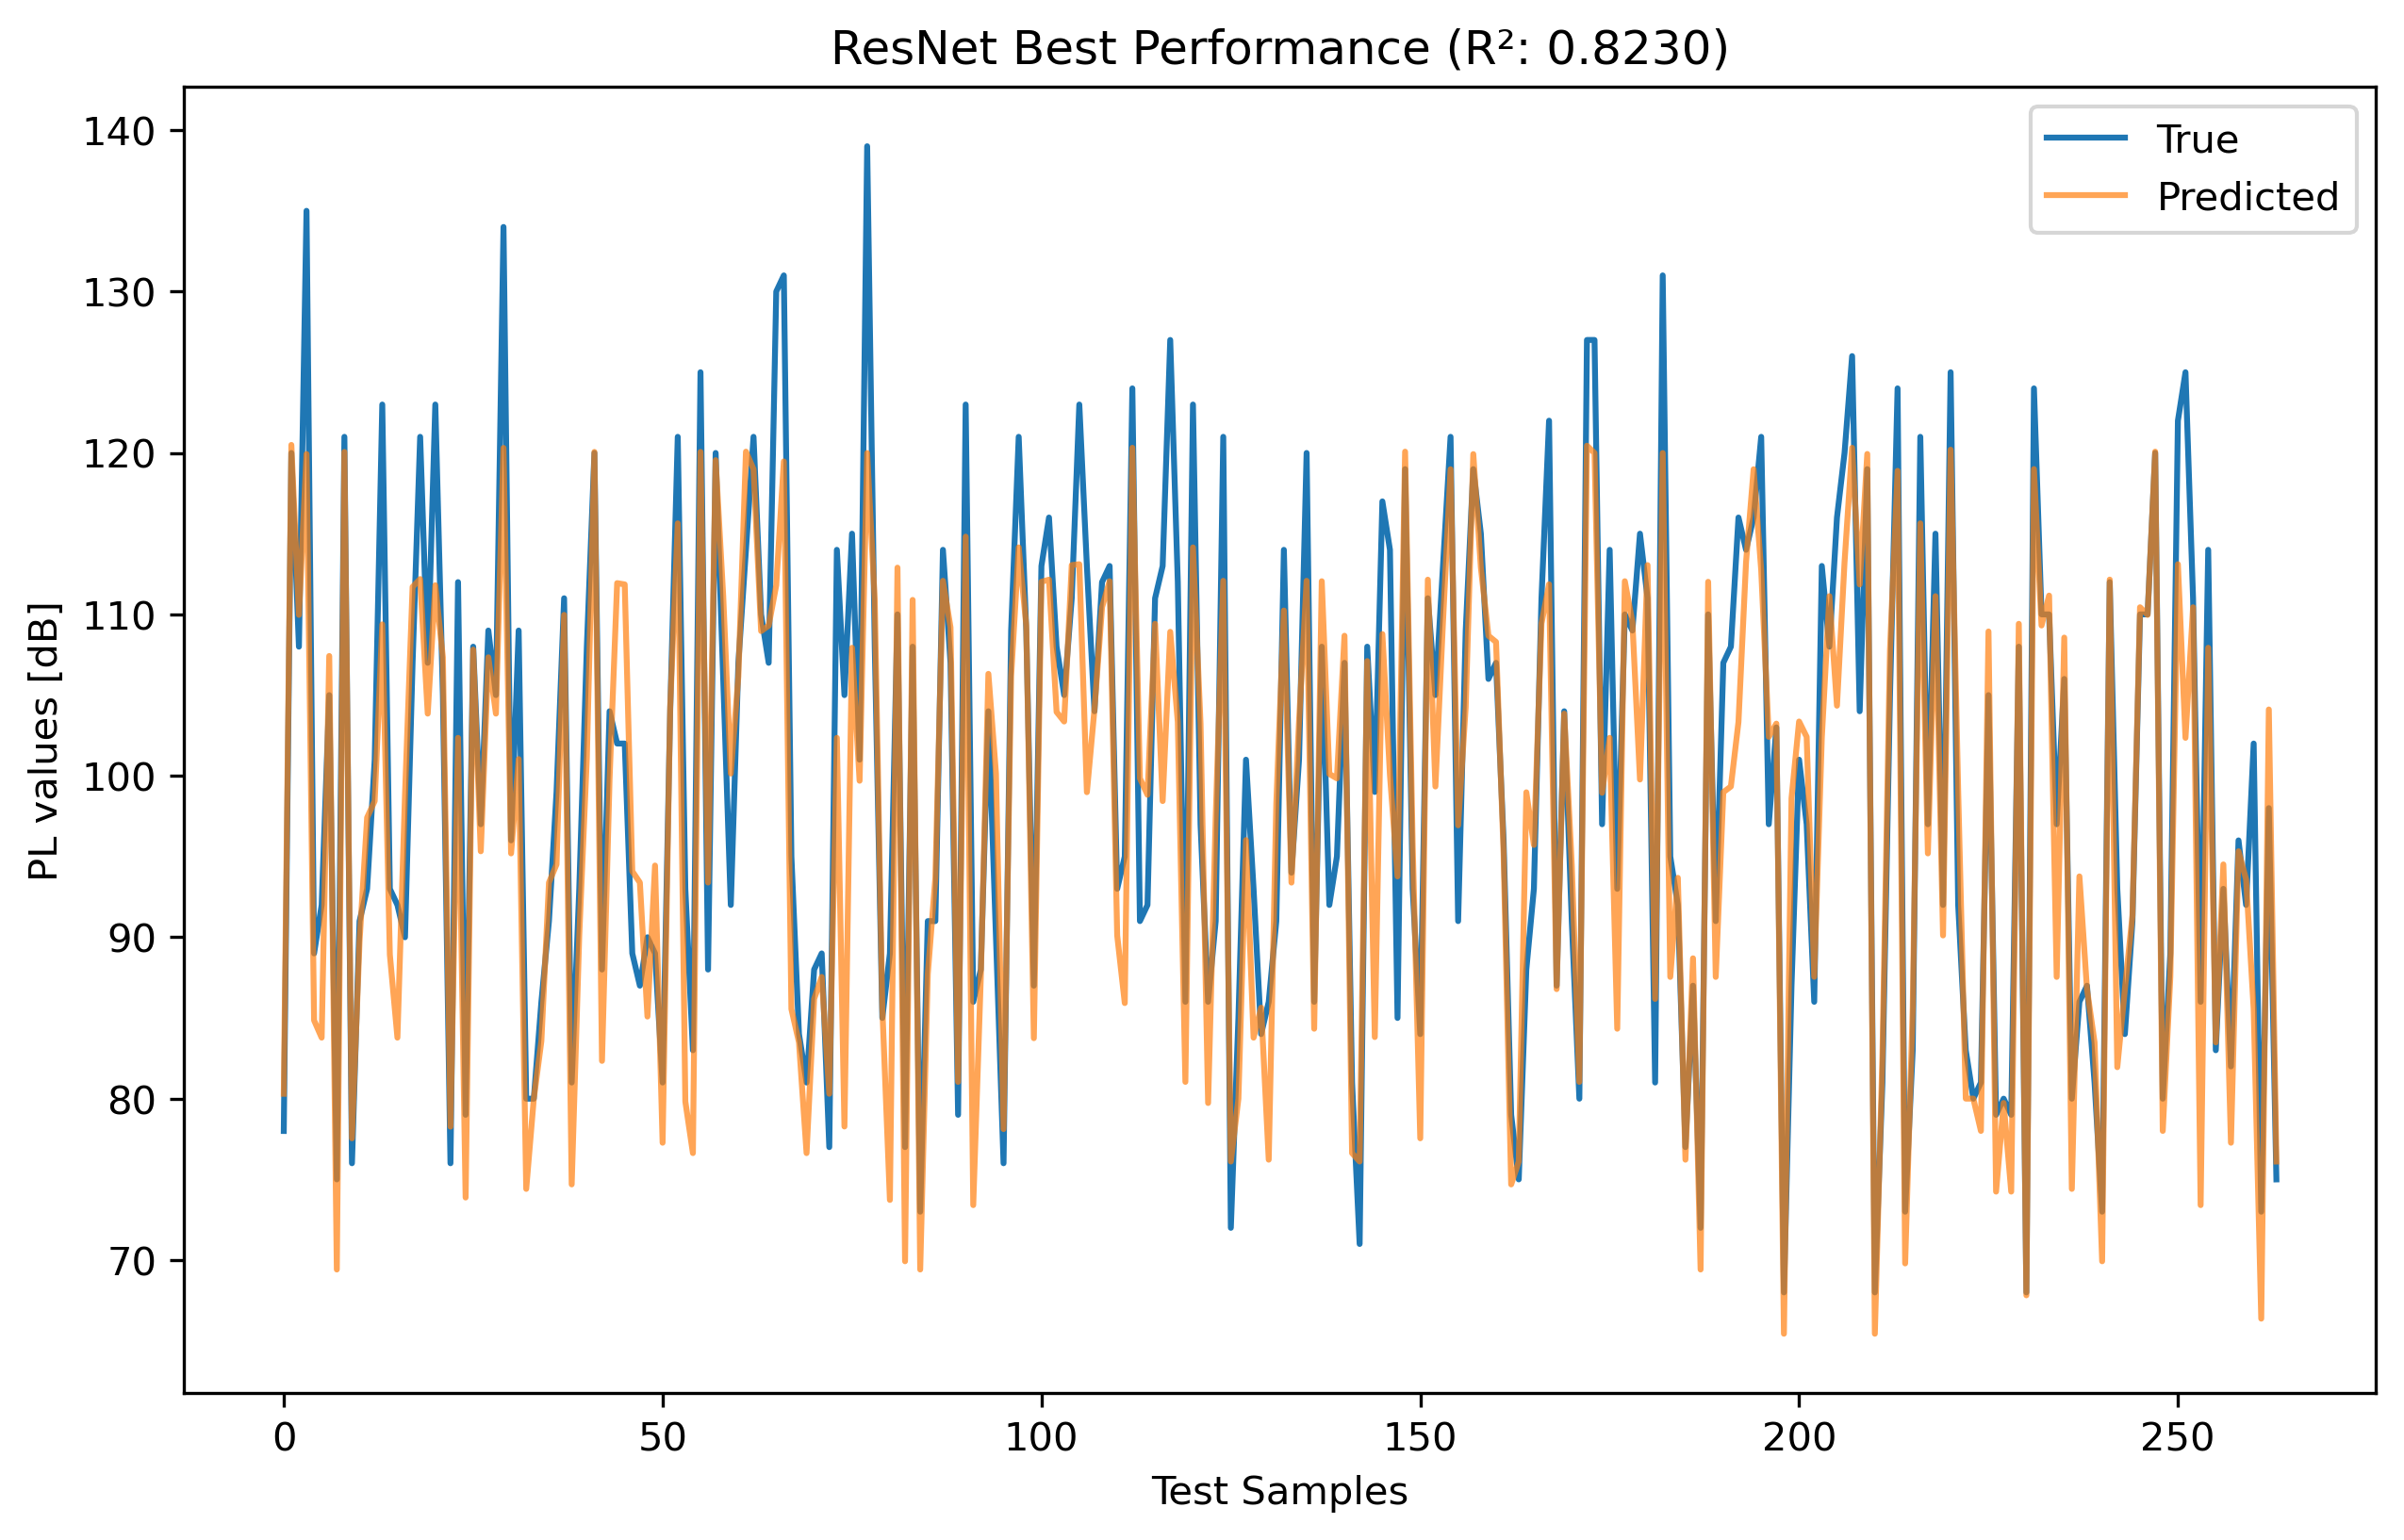

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 1. ResNet Architecture (Same as before) ---
class ResNetTabular(nn.Module):
    def __init__(self, num_features, hidden_dim=64, num_blocks=2, dropout=0.1):
        super(ResNetTabular, self).__init__()
        
        self.input_layer = nn.Linear(num_features, hidden_dim)
        
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.BatchNorm1d(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(dropout)
            ) for _ in range(num_blocks)
        ])
        
        self.output_norm = nn.BatchNorm1d(hidden_dim)
        self.output_act = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = self.input_layer(x)
        for block in self.blocks:
            out = out + block(out)
        out = self.output_norm(out)
        out = self.output_act(out)
        return self.output_layer(out)

# --- 2. Data Loading (Raw Data Only) ---
try:
    indoor_data = pd.read_excel('csv_experiments.xlsx', sheet_name='Indoor', header=0)
except FileNotFoundError:
    print("Generating dummy data for testing...")
    indoor_data = pd.DataFrame({
        'nw': np.random.randint(1, 5, 200),
        'nf': np.random.randint(1, 5, 200),
        'd': np.random.uniform(1, 50, 200),
        'f': np.random.uniform(2e9, 5e9, 200),
        'PL': np.random.uniform(40, 90, 200)
    })

# Extract raw values (Scaling happens inside the loop!)
all_inputs = indoor_data[['nw', 'nf', 'd', 'f']].values.astype(np.float32)
all_labels = indoor_data['PL'].values.astype(np.float32)

# --- 3. Rigorous Evaluation Loop ---
num_runs = 10
epochs = 150
batch_size = 32

# Store metrics for all runs
results = {'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': [], 'R2': []}

# Variables to save the best model for plotting
best_model_state = None
best_r2 = -np.inf
best_data = {} # To store the specific split associated with the best run

print(f"Starting {num_runs} runs (Reshuffling Data Each Time)...")

for run in range(num_runs):
    # --- A. Random Split (Monte Carlo CV) ---
    # Changing random_state ensures a different split every time
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        all_inputs, all_labels, test_size=0.2, random_state=run
    )

    # --- B. Scaling (Fit only on Train to avoid Leakage) ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    # --- C. Prepare Tensors ---
    train_dataset = TensorDataset(torch.tensor(X_train_scaled), torch.tensor(y_train).unsqueeze(1))
    # We load all test data at once for evaluation simplicity
    X_test_tensor = torch.tensor(X_test_scaled).to(device)
    y_test_tensor = torch.tensor(y_test).unsqueeze(1) # Keep on CPU for metrics calc unless large

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # --- D. Initialize Model ---
    model = ResNetTabular(num_features=4, hidden_dim=64, num_blocks=2, dropout=0.1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.MSELoss()

    # --- E. Training ---
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # --- F. Evaluation ---
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu()
        
        mse = mean_squared_error(y_test_tensor, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_tensor, preds)
        mape = mean_absolute_percentage_error(y_test_tensor, preds) * 100
        r2 = r2_score(y_test_tensor, preds)

        results['MSE'].append(mse)
        results['RMSE'].append(rmse)
        results['MAE'].append(mae)
        results['MAPE'].append(mape)
        results['R2'].append(r2)

        print(f"Run {run+1}: R²={r2:.4f} | MSE={mse:.4f}")

        # Save info if this is the best model so far
        if r2 > best_r2:
            best_r2 = r2
            best_model_state = copy.deepcopy(model.state_dict())
            best_data = {'y_test': y_test, 'X_test_scaled': X_test_scaled}

# --- 4. Statistics & Plotting ---
print("\n" + "="*40)
print(f"FINAL STATISTICS ({num_runs} different splits)")
print("="*40)

stats_df = pd.DataFrame(results)
summary = stats_df.describe().loc[['mean', 'std']].T
summary['formatted'] = summary.apply(lambda x: f"{x['mean']:.4f} ± {x['std']:.4f}", axis=1)
print(summary['formatted'])

# Plot Best Run
print(f"\nPlotting Best Run (R²: {best_r2:.4f})")
final_model = ResNetTabular(num_features=4, hidden_dim=64, num_blocks=2).to(device)
final_model.load_state_dict(best_model_state)
final_model.eval()

with torch.no_grad():
    X_best_tensor = torch.tensor(best_data['X_test_scaled']).to(device)
    y_pred_best = final_model(X_best_tensor).cpu().numpy().ravel()
    y_true_best = best_data['y_test']

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(range(len(y_true_best)), y_true_best, label='True')
plt.plot(range(len(y_pred_best)), y_pred_best, label='Predicted', alpha=0.7)
plt.ylabel('PL values [dB]')
plt.xlabel('Test Samples')
plt.title(f'ResNet Best Performance (R²: {best_r2:.4f})')
plt.legend()
plt.show()

## TabNet

Using device: cuda
Starting 10 runs with TabNet...

Early stopping occurred at epoch 64 with best_epoch = 49 and best_valid_mse = 40.91735076904297
Run 1: R²=0.8155 | MSE=40.9174


/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 75 with best_epoch = 60 and best_valid_mse = 45.78982162475586
Run 2: R²=0.8287 | MSE=45.7898


/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 27 and best_valid_mse = 51.54859161376953
Run 3: R²=0.7839 | MSE=51.5486


/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 72 with best_epoch = 57 and best_valid_mse = 47.43349838256836
Run 4: R²=0.8072 | MSE=47.4335


/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 69 with best_epoch = 54 and best_valid_mse = 38.746238708496094
Run 5: R²=0.8431 | MSE=38.7462


/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 14 and best_valid_mse = 47.536720275878906
Run 6: R²=0.8117 | MSE=47.5367


/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 44 and best_valid_mse = 38.63283920288086
Run 7: R²=0.8495 | MSE=38.6328


/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 29 and best_valid_mse = 38.29518127441406
Run 8: R²=0.8429 | MSE=38.2952


/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 41 and best_valid_mse = 41.28583908081055
Run 9: R²=0.8383 | MSE=41.2858


/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 39 and best_valid_mse = 49.99525833129883
Run 10: R²=0.7845 | MSE=49.9953

TABNET FINAL STATISTICS (10 runs)
MSE     44.0181 ± 5.0138
RMSE     6.6250 ± 0.3769
MAE      5.1423 ± 0.2860
MAPE     5.0857 ± 0.2825
R2       0.8205 ± 0.0239
Name: formatted, dtype: object

Plotting Best Run (R²: 0.8495)


/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


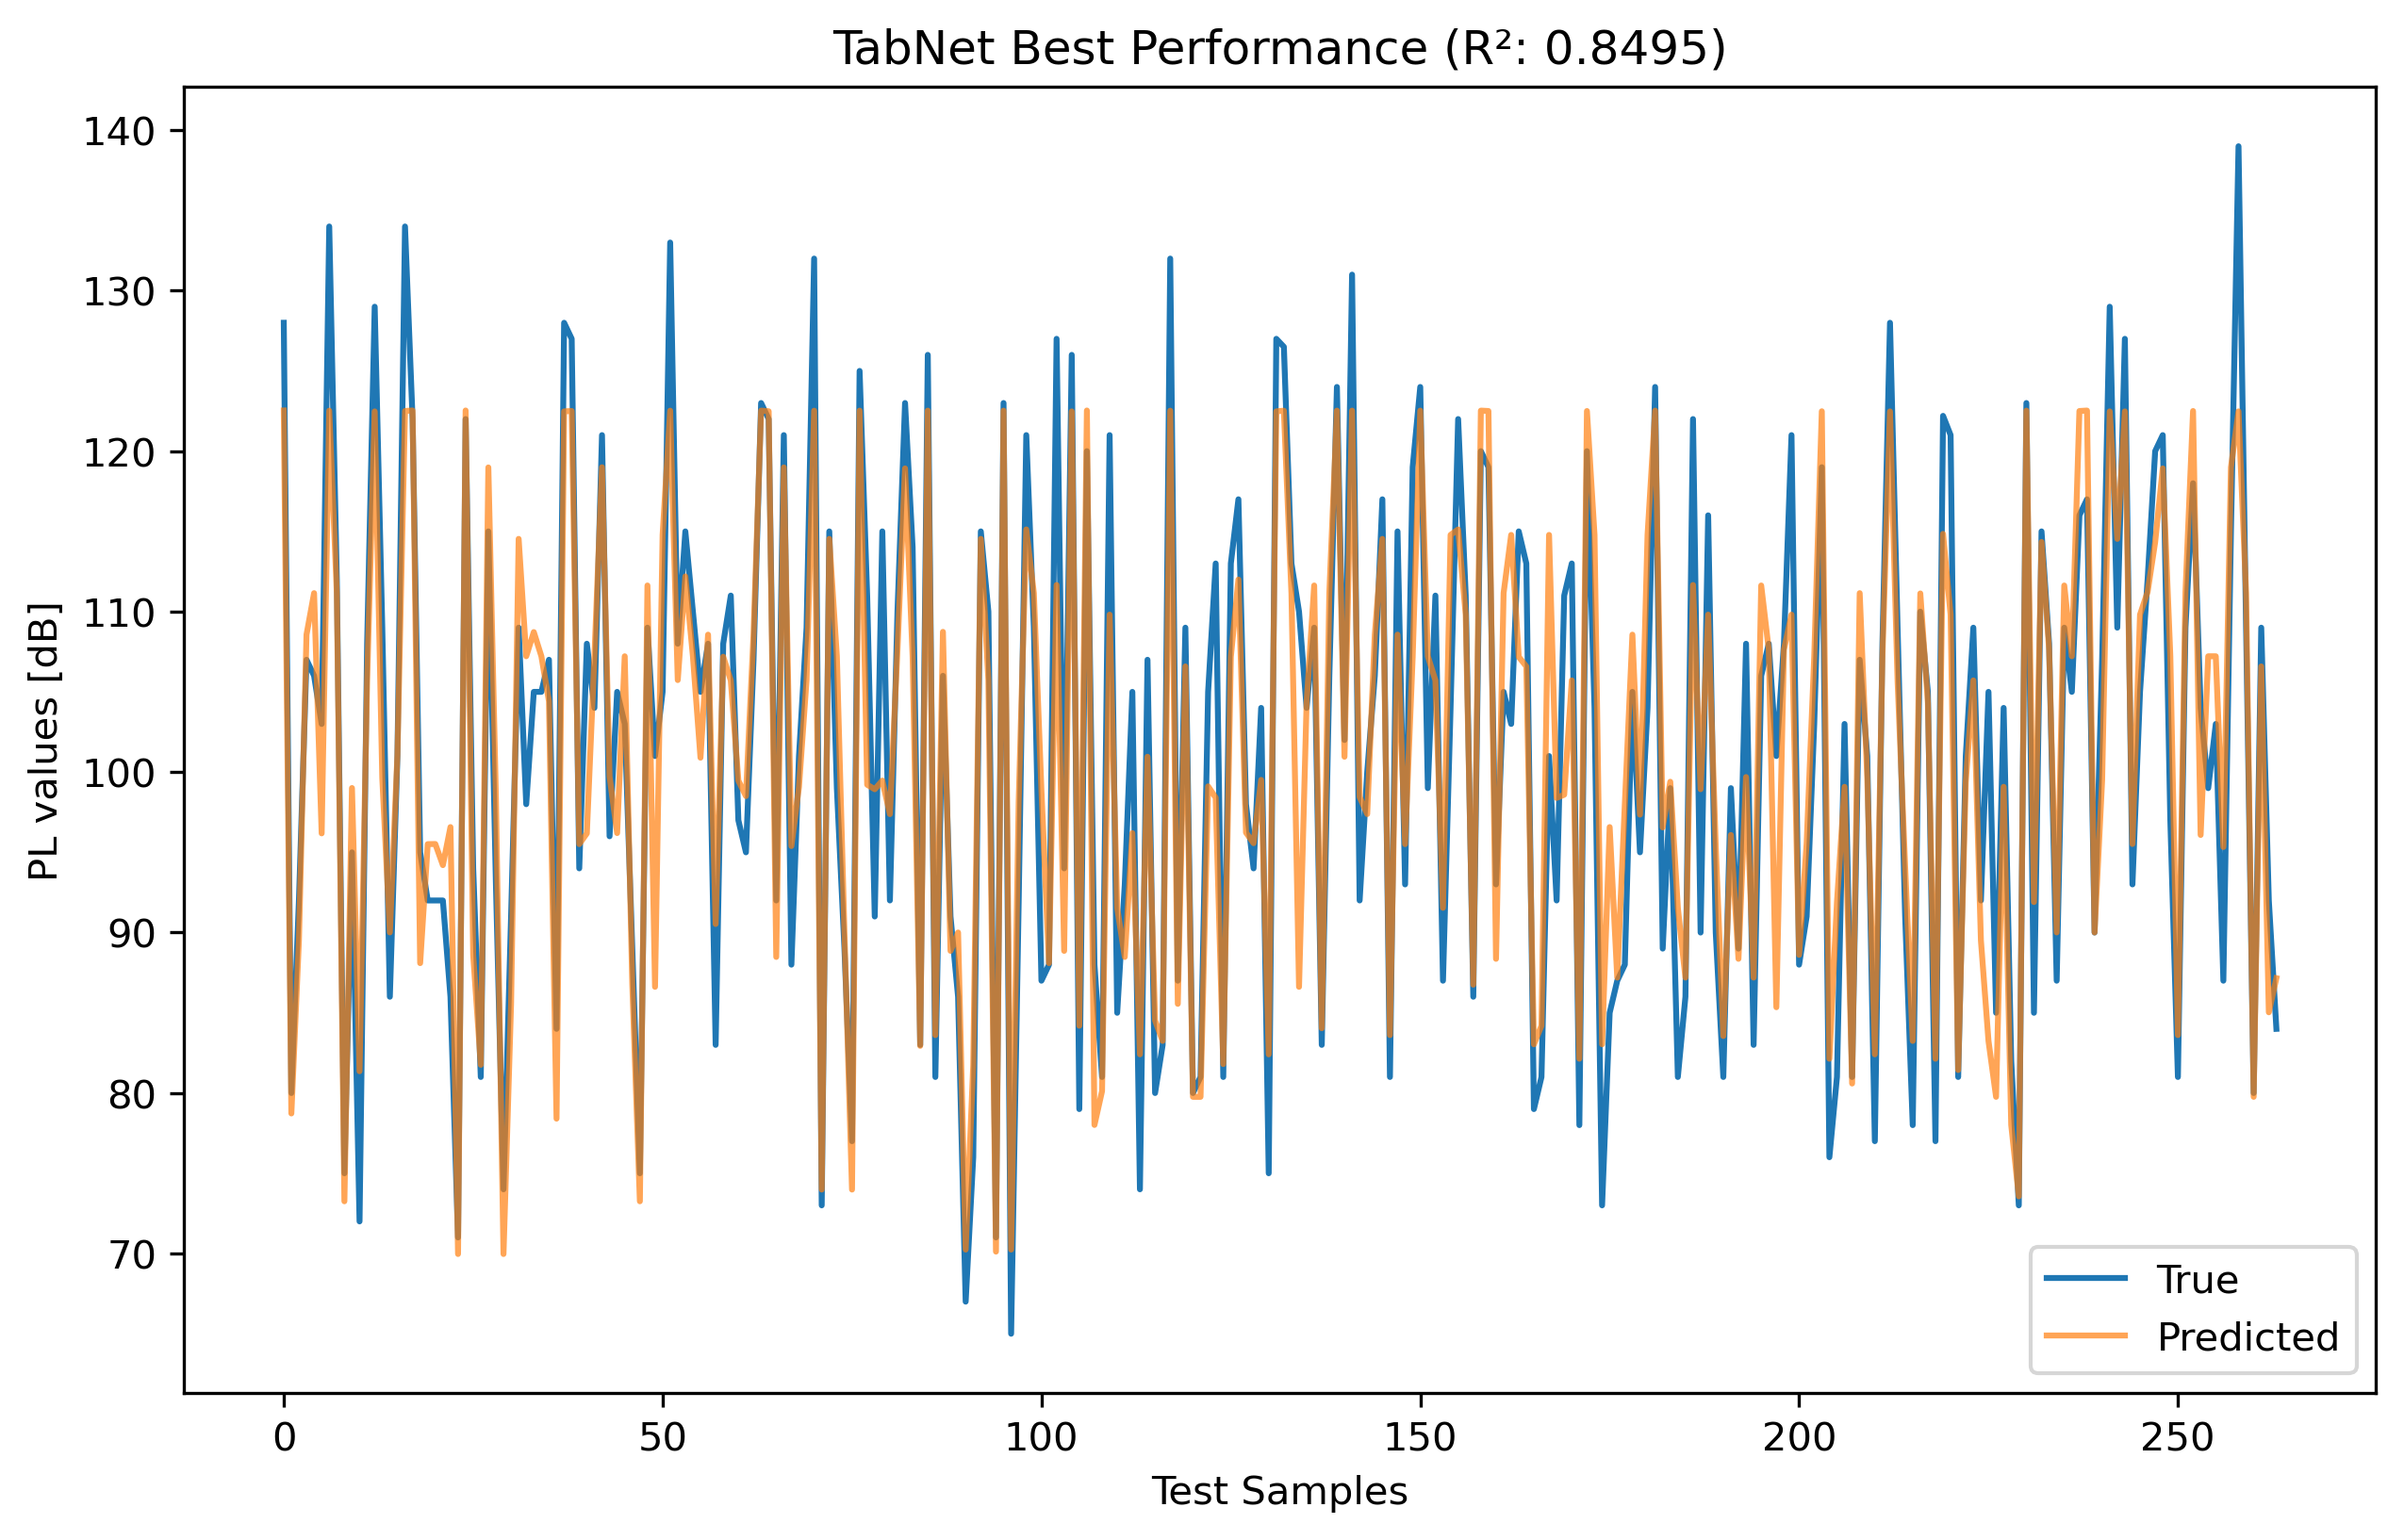


Global Feature Importance (Best Run):
nw: 0.1332
nf: 0.2643
d: 0.5505
f: 0.0520


In [4]:
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import copy

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# --- 1. Data Loading ---
try:
    indoor_data = pd.read_excel('csv_experiments.xlsx', sheet_name='Indoor', header=0)
except FileNotFoundError:
    print("Generating dummy data for testing...")
    indoor_data = pd.DataFrame({
        'nw': np.random.randint(1, 5, 200),
        'nf': np.random.randint(1, 5, 200),
        'd': np.random.uniform(1, 50, 200),
        'f': np.random.uniform(2e9, 5e9, 200),
        'PL': np.random.uniform(40, 90, 200)
    })

all_inputs = indoor_data[['nw', 'nf', 'd', 'f']].values.astype(np.float32)
all_labels = indoor_data['PL'].values.astype(np.float32)

# --- 2. Rigorous Evaluation Loop ---
num_runs = 10
epochs = 150
batch_size = 32
results = {'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': [], 'R2': []}

# Variables to store best run for plotting
best_model = None
best_r2 = -np.inf
best_data = {} 

print(f"Starting {num_runs} runs with TabNet...")

for run in range(num_runs):
    # --- A. Random Split (Monte Carlo CV) ---
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        all_inputs, all_labels, test_size=0.2, random_state=run
    )

    # --- B. Scaling ---
    # TabNet converges faster with scaled data, even if not strictly required
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)
    
    # Reshape targets for TabNet (N, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # --- C. Initialize TabNet ---
    # Resetting the model every loop
    regressor = TabNetRegressor(
        n_d=16, n_a=16,       # Attention/Decision dimensions (Tunable)
        n_steps=3,            # Number of steps
        optimizer_params=dict(lr=0.02),
        verbose=0,            # Silence per-epoch printing
        seed=run,             # Reproducibility within the run
        device_name=device
    )

    # --- D. Training ---
    # TabNet handles the validation loop internally via eval_set
    regressor.fit(
        X_train=X_train_scaled, y_train=y_train,
        eval_set=[(X_test_scaled, y_test)],
        eval_name=['valid'],
        eval_metric=['mse'],
        max_epochs=epochs,
        patience=15,          # Early stopping
        batch_size=batch_size,
        virtual_batch_size=32,
        num_workers=0,
        drop_last=False
    )

    # --- E. Evaluation ---
    preds = regressor.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds) * 100
    r2 = r2_score(y_test, preds)

    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['MAE'].append(mae)
    results['MAPE'].append(mape)
    results['R2'].append(r2)

    print(f"Run {run+1}: R²={r2:.4f} | MSE={mse:.4f}")

    # Save best model
    if r2 > best_r2:
        best_r2 = r2
        best_model = regressor # pytorch_tabnet models are picklable/copyable
        best_data = {'y_test': y_test, 'X_test_scaled': X_test_scaled}

# --- 3. Statistics & Visualization ---
print("\n" + "="*40)
print(f"TABNET FINAL STATISTICS ({num_runs} runs)")
print("="*40)

stats_df = pd.DataFrame(results)
summary = stats_df.describe().loc[['mean', 'std']].T
summary['formatted'] = summary.apply(lambda x: f"{x['mean']:.4f} ± {x['std']:.4f}", axis=1)
print(summary['formatted'])

# --- 4. Plotting Best Run ---
print(f"\nPlotting Best Run (R²: {best_r2:.4f})")
y_pred_best = best_model.predict(best_data['X_test_scaled'])
y_true_best = best_data['y_test']

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(range(len(y_true_best)), y_true_best, label='True')
plt.plot(range(len(y_pred_best)), y_pred_best, label='Predicted', alpha=0.7)
plt.ylabel('PL values [dB]')
plt.xlabel('Test Samples')
plt.title(f'TabNet Best Performance (R²: {best_r2:.4f})')
plt.legend()
plt.show()

# --- 5. Feature Importance (Bonus) ---
# TabNet provides global feature importance out of the box
print("\nGlobal Feature Importance (Best Run):")
feature_names = ['nw', 'nf', 'd', 'f']
importances = best_model.feature_importances_
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")